In [1]:
import sympy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import dill
from tqdm import tqdm
from triangle import triangulate, plot
from random import sample
from utils import (
    get_global_normals_and_tangentials,
    get_local_normals_and_tangentials,
    get_middle_indices,
    get_delta_function,
)
dill.settings["recurse"] = True

### Get precomputed integrals

In [42]:
biharmonic_functional = dill.load(
    open("../calculations/argyris_quitic_biharmonic_matrix", "rb")
)
basis_integral_values = dill.load(
    open("../calculations/argyris_quitic_biharmonic_right_values", "rb")
)

### Initialize the domain

In [44]:
t = np.linspace(0 + np.pi / 4, 2 * np.pi + np.pi / 4, 30, endpoint=False)
points = np.stack((np.cos(t), np.sin(t))).T
seg = np.array(
    [[j, j + 1] for j in range(points.shape[0] - 1)] + [[points.shape[0] - 1, 0]]
)

### Run triangulation

In [45]:
cndt = triangulate({"vertices": points, "segments": seg}, opts="q30a0.3neo2")
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
triangles_s = points[triangles]
vertex_maker_is_boundary = cndt["vertex_markers"]
print(f"Total number of points:\t\t{points.shape[0]}\nTotal number of elements:\t{triangles.shape[0]}")

Total number of points:		187
Total number of elements:	78


### Local normal and tangential vectors

In [46]:
elem_normal, elem_tangential = get_local_normals_and_tangentials(points, triangles)

### Global normal and tangential

In [47]:
global_elem_normal, global_elem_tangential = get_global_normals_and_tangentials(
    points, triangles
)

### Separate middles

In [48]:
is_middle = get_middle_indices(points.shape[0], triangles)

### Visualize triangulation

100%|█████████████████████████████████████████| 78/78 [00:00<00:00, 1635.47it/s]


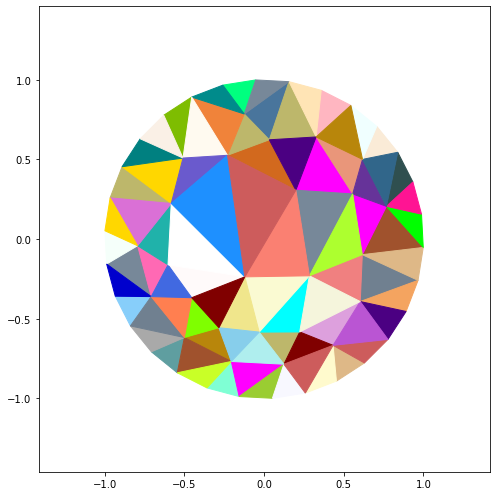

In [49]:
all_colors = (
    100 * list(mcolors.CSS4_COLORS.keys())
    + list(mcolors.XKCD_COLORS.keys())
    + list(mcolors.BASE_COLORS.keys())
)
colors = sample(all_colors, triangles_s.shape[0])

%matplotlib inline
fig, ax = plt.subplots(figsize=(7, 7))
ax.axis("equal")

for index, triangle in enumerate(tqdm(triangles_s)):
    t1 = plt.Polygon(triangle[:3], color=colors[index])
    fig.gca().add_patch(t1)

if False:
    for idx, point in enumerate(tqdm(points)):
        if vertex_maker_is_boundary[idx] == 0:
            color = "red"
        else:
            color = "green"
        ax.scatter(point[0], point[1], color=color)

ax.set_xlim([points[:, 0].min() - 0.5, points[:, 0].max() + 0.5])
ax.set_ylim([points[:, 1].min() - 0.5, points[:, 1].max() + 0.5])
fig.tight_layout()
plt.show()

### Initialize variables

In [50]:
total_points = points.shape[0]
num_midpoints = is_middle.sum()
num_nodes = total_points - num_midpoints
NUM = 6 * num_nodes + num_midpoints

In [51]:
x, y = sympy.symbols("x y")

In [52]:
right_part_values = np.zeros((total_points, 6))

### Define the right part of the equation

In [53]:
F = sympy.Float(1)
F_x = F.diff(x)
F_y = F.diff(y)
F_xx = F_x.diff(x)
F_xy = F_x.diff(y)
F_yy = F_y.diff(y)

In [54]:
right_part_values[:, 0] = sympy.lambdify((x, y), F   )(*points.T)
right_part_values[:, 1] = sympy.lambdify((x, y), F_x )(*points.T)
right_part_values[:, 2] = sympy.lambdify((x, y), F_y )(*points.T)
right_part_values[:, 3] = sympy.lambdify((x, y), F_xx)(*points.T)
right_part_values[:, 4] = sympy.lambdify((x, y), F_xy)(*points.T)
right_part_values[:, 5] = sympy.lambdify((x, y), F_yy)(*points.T)

### This is for Green's function

In [55]:
# right_part_values = get_delta_function(np.array([0, 0]), points, triangles, elem_normal, elem_tangential, global_elem_normal, global_elem_tangential, num_nodes, basis_integral_values)

### Stiffnes matrix assembling

In [56]:
matrix = np.zeros((NUM, NUM))
b = np.zeros((NUM))

for idx, element in enumerate(tqdm(triangles)):
    # ----------------P's----------------------------------------------------------------
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]

    delta = x1 * y2 - x1 * y3 - x2 * y1 + x2 * y3 + x3 * y1 - x3 * y2

    P_1_x = (-y1 + y3) / delta
    P_1_y = (+x1 - x3) / delta

    P_2_x = (+y1 - y2) / delta
    P_2_y = (-x1 + x2) / delta
    # ------------------------------------------------------------------------------------
    # ----------------------Lengths-------------------------------------------------------
    l1 = ((x2 - x3) ** 2 + (y2 - y3) ** 2) ** 0.5
    l2 = ((x1 - x3) ** 2 + (y1 - y3) ** 2) ** 0.5
    l3 = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
    # ------------------------------------------------------------------------------------
    # ----------------------Jacobian------------------------------------------------------
    J = np.array([[P_1_x, P_1_y], [P_2_x, P_2_y]])

    J_inv_T = np.linalg.inv(J).T
    # -----------------------------------------------------------------------------------
    # -----------------------nomal-and-tangential-vectors--------------------------------
    n1 = elem_normal[idx, 3]
    n2 = elem_normal[idx, 4]
    n3 = elem_normal[idx, 5]    
    t1 = elem_tangential[idx, 3]
    t2 = elem_tangential[idx, 4]
    t3 = elem_tangential[idx, 5]

    DN_n1 = global_elem_normal[triangles[idx]][3]
    DN_n2 = global_elem_normal[triangles[idx]][4]
    DN_n3 = global_elem_normal[triangles[idx]][5]    
    DN_t1 = global_elem_tangential[triangles[idx]][3]
    DN_t2 = global_elem_tangential[triangles[idx]][4]
    DN_t3 = global_elem_tangential[triangles[idx]][5]
    # ------------------------------------------------------------------------------------
    # ------------------------G's---------------------------------------------------------
    G1 = np.array([[*n1], [*t1]])
    G2 = np.array([[*n2], [*t2]])
    G3 = np.array([[*n3], [*t3]])
    
    G1_hat = np.array([[+np.sqrt(1 / 2), +np.sqrt(1 / 2)], [-np.sqrt(1 / 2), +np.sqrt(1 / 2)],])
    G2_hat = np.array([[-1, +0], [+0, -1],])
    G3_hat = np.array([[+0, -1], [+1, +0]])
    
    B1 = G1_hat @ J_inv_T @ G1.T
    B2 = G2_hat @ J_inv_T @ G2.T
    B3 = G3_hat @ J_inv_T @ G3.T
    
    DN_G1 = np.array([[*DN_n1], [*DN_t1]])
    DN_G2 = np.array([[*DN_n2], [*DN_t2]])
    DN_G3 = np.array([[*DN_n3], [*DN_t3]])
    
    DN_B1 = G1_hat @ J_inv_T @ DN_G1.T
    DN_B2 = G2_hat @ J_inv_T @ DN_G2.T
    DN_B3 = G3_hat @ J_inv_T @ DN_G3.T
    
    # ------------------------------------------------------------------------------------
    # ----------------------Theta---------------------------------------------------------
    THETA = np.array(
        [
            [P_1_x**2, 2 * P_1_x * P_2_x, P_2_x**2],
            [P_1_y * P_1_x, P_1_y * P_2_x + P_1_x * P_2_y, P_2_x * P_2_y],
            [P_1_y**2, 2 * P_1_y * P_2_y, P_2_y**2],
        ]
    )
    # ------------------------------------------------------------------------------------
    # -------------------------right-part-interp------------------------------------------
    right_part_interp = [
        *right_part_values[element[0]],
        *right_part_values[element[1]],
        *right_part_values[element[2]],
        n1 @ right_part_values[element[3]][1:3],#?????
        n2 @ right_part_values[element[4]][1:3],#?????
        n3 @ right_part_values[element[5]][1:3],#?????
    ]
    # ------------------------------------------------------------------------------------
    # --------------------args------------------------------------------------------------
    args = [
        *n1,*n2,*n3,
        *t1,*t2,*t3,
        l1,l2,l3,
        *J.flatten(),
        *THETA.flatten(),
        *B1.flatten(),*B2.flatten(),*B3.flatten(),
        *DN_B1.flatten(),*DN_B2.flatten(),*DN_B3.flatten(),
        *right_part_interp,
    ]

    vals = biharmonic_functional(*args)
    vals_A = basis_integral_values(*args)

    # ------------------------------------------------------------------------------------
    for point_idx in range(3):

        if vertex_maker_is_boundary[element[point_idx]] == True:

            matrix[6*element[point_idx]+0, 6*element[point_idx]+0] = 1

            for i in range(1, 6):
                for j in range(3):
                    for k in range(6):
                        matrix[6*element[point_idx]+i, 6*element[j]+k] += (
                            2*vals[6*point_idx+i, 6*j+k]
                        )
                        
                    for k in range(3, 6):
                        matrix[6*element[point_idx]+i, 6*num_nodes+(element[k]-num_nodes)] += (
                            2*vals[6*point_idx+i,18+(k-3)]
                        )

            b[6 * element[point_idx] + 0] = 0
            b[6 * element[point_idx] + 1] += 2 * vals_A[6 * point_idx + 1]
            b[6 * element[point_idx] + 2] += 2 * vals_A[6 * point_idx + 2]
            b[6 * element[point_idx] + 3] += 2 * vals_A[6 * point_idx + 3]
            b[6 * element[point_idx] + 4] += 2 * vals_A[6 * point_idx + 4]
            b[6 * element[point_idx] + 5] += 2 * vals_A[6 * point_idx + 5]
            
        else:
            for i in range(6):
                for j in range(3):
                    for k in range(6):
                        matrix[6*element[point_idx]+i, 6*element[j]+k] += (
                            2*vals[6*point_idx+i, 6*j+k]
                        )
                        
                    for k in range(3, 6):
                        matrix[6*element[point_idx]+i, 6*num_nodes+(element[k]-num_nodes)] += (
                            2*vals[6*point_idx+i, 18+(k-3)]
                        )

            b[6 * element[point_idx] + 0] += 2 * vals_A[6 * point_idx + 0]
            b[6 * element[point_idx] + 1] += 2 * vals_A[6 * point_idx + 1]
            b[6 * element[point_idx] + 2] += 2 * vals_A[6 * point_idx + 2]
            b[6 * element[point_idx] + 3] += 2 * vals_A[6 * point_idx + 3]
            b[6 * element[point_idx] + 4] += 2 * vals_A[6 * point_idx + 4]
            b[6 * element[point_idx] + 5] += 2 * vals_A[6 * point_idx + 5]

    for mid_idx in range(3, 6):

        if vertex_maker_is_boundary[element[mid_idx]] == True:
            matrix[
                6 * num_nodes + (element[mid_idx] - num_nodes),
                6 * num_nodes + (element[mid_idx] - num_nodes),
            ] = 1
            b[6*num_nodes+(element[mid_idx]-num_nodes)] = 0
        else:
            
            for j in range(3):
                for k in range(6):
                    matrix[
                        6 * num_nodes + (element[mid_idx] - num_nodes),
                        6 * element[j] + k,
                    ] += (
                        2 * vals[18 + (mid_idx - 3), 6 * j + k]
                    )

                for k in range(3, 6):
                    matrix[
                        6 * num_nodes + (element[mid_idx] - num_nodes),
                        6 * num_nodes + (element[k] - num_nodes),
                    ] += (
                        2 * vals[18 + (mid_idx - 3), 18 + (k - 3)]
                    )
            b[6 * num_nodes + (element[mid_idx] - num_nodes)] += (
                2 * vals_A[18 + (mid_idx - 3)]
            )

100%|███████████████████████████████████████████| 78/78 [00:10<00:00,  7.34it/s]


### Visualize stiffness matrix

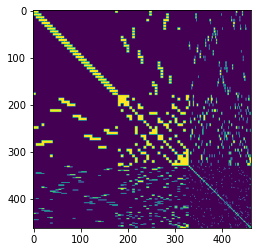

In [57]:
fig, ax = plt.subplots()
ax.imshow(matrix != 0)
plt.show()

### Solve the system

In [58]:
c = np.linalg.solve(matrix, b)

In [59]:
U = (1-x**2-y**2)**2/64
U_x =  sympy.lambdify((x, y), U.diff(x)   )(*points.T[:, :num_nodes])
U_y =  sympy.lambdify((x, y), U.diff(y)   )(*points.T[:, :num_nodes])
U_xx = sympy.lambdify((x, y), U.diff(x, x))(*points.T[:, :num_nodes])
U_xy = sympy.lambdify((x, y), U.diff(x, y))(*points.T[:, :num_nodes])
U_yy = sympy.lambdify((x, y), U.diff(y, y))(*points.T[:, :num_nodes])
U    = sympy.lambdify((x, y), U           )(*points.T[:, :num_nodes])

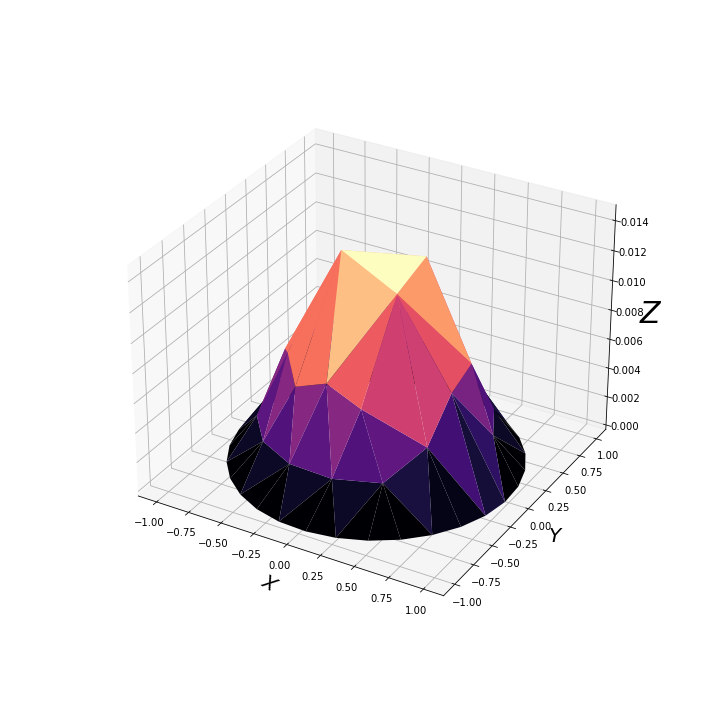

In [69]:
%matplotlib widget

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.set_xlabel("$X$", fontsize=20, rotation=150)
ax.set_ylabel("$Y$", fontsize=20, rotation=0)
ax.set_zlabel("$Z$", fontsize=30, rotation=0)

_x_ = points[:num_nodes, 0]
_y_ = points[:num_nodes, 1]
_x_n = points[num_nodes:, 0]
_y_n = points[num_nodes:, 1]


F =   c[0 : (6 * num_nodes) : 6]
Fx =  c[1 : (6 * num_nodes) : 6]
Fy =  c[2 : (6 * num_nodes) : 6]
Fxx = c[3 : (6 * num_nodes) : 6]
Fxy = c[4 : (6 * num_nodes) : 6]
Fyy = c[5 : (6 * num_nodes) : 6]
Fn =  c[6 * num_nodes :]

ax.plot_trisurf(
    _x_,
    _y_,
    F,
    triangles=triangles[:, :3],
    cmap="magma",
)

# ax.set_box_aspect((np.ptp(points[:, 0]), np.ptp(points[:, 1]), 200*np.ptp(F)))
plt.show()

In [61]:
abs(U - F).max() / abs(U).max()

0.09207340044251722

In [62]:
abs(U_x - Fx).max() / abs(U_x).max()

0.3086459420261187

In [63]:
abs(U_y - Fy).max() / abs(U_y).max()

0.3044011753466704

In [64]:
abs(U_xx - Fxx).max() / abs(U_xx).max()

1.6477389523380974

In [65]:
abs(U_xy - Fxy).max() / abs(U_xy).max()

2.6998433533274264

In [66]:
abs(U_yy - Fyy).max() / abs(U_yy).max()

1.4990362215237962